In [1]:
!git clone https://github.com/kruglov-dmitry/CFLD.git

Cloning into 'CFLD'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 236 (delta 34), reused 20 (delta 18), pack-reused 189
Receiving objects: 100% (236/236), 23.17 MiB | 9.35 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [2]:
%cd CFLD

/content/CFLD


In [ ]:
!wget https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/unet/diffusion_pytorch_model.safetensors

In [4]:
!mv diffusion_pytorch_model.safetensors pretrained_models/unet/

In [ ]:
!wget https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/vae/diffusion_pytorch_model.safetensors

In [6]:
!mv diffusion_pytorch_model.safetensors pretrained_models/vae/

In [ ]:
!wget https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window12_384_22kto1k.pth

In [8]:
!mkdir pretrained_models/swin && mv swin_base_patch4_window12_384_22kto1k.pth pretrained_models/swin/

In [ ]:
!pip install torchvision==0.15.2 numpy==1.23.1 xformers==0.0.21 yacs==0.1.6 pandas==2.0.3 scikit-image==0.20.0 gpustat==1.1 accelerate==0.23.0 tensorboard==2.13.0 wandb==0.15.11 einops==0.3.0 opencv-python==4.7.0.72 timm==0.9.7 diffusers==0.19.3 safetensors==0.3.1 scipy==1.10.1 lpips==0.1.4 transformers==4.35.0

In [ ]:
#!pip install optax==0.1.2 chex==0.1.2
!pip install jax==0.4.6 jaxlib==0.4.6 flax==0.4.1 chex==0.1.2 optax==0.1.2

In [2]:
%cd CFLD

/content/CFLD


In [3]:
!mkdir checkpoints

In [ ]:
#!wget https://drive.google.com/file/d/1YBdKFsMWVdOzedOmOJ_Bu4NL0LBpQGix?download&confirm=xxx
#!wget https://drive.usercontent.google.com/download?id=1YBdKFsMWVdOzedOmOJ_Bu4NL0LBpQGix&confirm=xxx
# from google.colab import files
# files.upload()
#!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1YBdKFsMWVdOzedOmOJ_Bu4NL0LBpQGix&confirm=xxx'
#wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YBdKFsMWVdOzedOmOJ_Bu4NL0LBpQGix' -O- | sed -rn 's/.confirm=([0-9A-Za-z_]+)./\1\n/p')&id=1YBdKFsMWVdOzedOmOJ_Bu4NL0LBpQGix" -O FILENAME && rm -rf /tmp/cookies.txt
!pip install gdown

In [ ]:
!gdown --fuzzy "https://drive.google.com/file/d/1YBdKFsMWVdOzedOmOJ_Bu4NL0LBpQGix/view?usp=drive_link"

In [ ]:
!gdown --fuzzy "https://drive.google.com/file/d/1g_tkMwey6_DET4puan90rOoad2HcFV6D/view?usp=drive_link"

In [7]:
!mv pytorch_model.bin checkpoints/
!mv pytorch_model_1.bin checkpoints/

In [ ]:
from diffusers import DDPMScheduler
from defaults import pose_transfer_C as cfg
from pose_transfer_train import build_model
from diffusers.configuration_utils import register_to_config
from models import UNet, VariationalAutoencoder
import torch
import os
import numpy as np
import pandas as pd
from pose_utils import (cords_to_map, draw_pose_from_cords,
                        load_pose_cords_from_strings)
import random
from PIL import Image
from torchvision import transforms
import copy
import cv2

noise_scheduler = DDPMScheduler.from_pretrained("pretrained_models/scheduler/scheduler_config.json")
vae = VariationalAutoencoder(pretrained_path="pretrained_models/vae").eval().requires_grad_(False).cuda()
model = build_model(cfg).eval().requires_grad_(False).cuda()
unet = UNet(cfg).eval().requires_grad_(False).cuda()

print(model.load_state_dict(torch.load(
    os.path.join("checkpoints", "pytorch_model.bin"), map_location="cpu"
), strict=False))
print(unet.load_state_dict(torch.load(
    os.path.join("checkpoints", "pytorch_model_1.bin"), map_location="cpu"
), strict=False))

In [ ]:
from google.colab import files
files.upload()

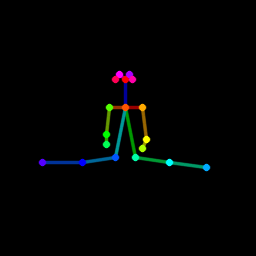

In [46]:
from pose_utils import (cords_to_map, draw_pose_from_cords,
                        load_pose_cords_from_strings)

def build_pose_img():
    # array = load_pose_cords_from_strings(
    #     "[-1, 36, 32, 29, 36, 29, 49, 49, 89, 89, 116, 119, 86, 82, 129, 132, 132, 136]",
    #     "[-1, 176, 179, 173, 173, 159, 149, 159, 156, 159, 159, 156, 103, 119, 113, 143, 89, 99]"
    # )
    # array = load_pose_cords_from_strings(
    #     "[36, 32, 29, 36, 29, 49, 49, 89, 89, 116, 119, 86, 82, 129, 132, 132, 136, -1]",
    #     "[176, 179, 173, 173, 159, 149, 159, 156, 159, 159, 156, 103, 119, 113, 143, 89, 99, -1]",
    # )
    # nose, neck, left shoulder, left elbow, left arm, right shoulder, right elbow, right arm
    # left_leg_start, left_knee, left_foot, right_leg_start, right_knee, right_foot,
    # left eye, right eye, left ear, right ear
    # array = load_pose_cords_from_strings(
    # "[25, 50, 50, 55, 60, 49, 84, 115, 115, 167, 226, 116, 171, 208, 20, 20, 24, 23]", # y
    #  "[88, 91, 72, 48, 24, 110, 117, 119, 74, 68, 66, 100, 130, 118, 84, 94, 80, 101]" # x
    # )

    array = load_pose_cords_from_strings(
        # test case 1
      # "[94, 100, 109, 134, 154, 91, 81, 69, 146, 189, 229, 134, 101, 144, 91, 89, 91, 84]", # y
      # "[116, 99, 111, 119, 131, 86, 61, 41, 81, 81, 79, 71, 54, 44, 119, 116, 119, 109]" # x
        # "[54, 74, 74, 135, 176, 74, 135, 181, 130, 196, 201, 125, 201, 206, 49, 44, 49, 44]",
        # "[267, 235, 227, 237, 242, 242, 242, 237, 156, 171, 136, 181, 217, 151, 273, 262, 257, 242]"
        # "[51, 73, 71, 96, 116, 74, 104, 121, 129, 134, 204, 131, 136, 204, 49, 49, 51, 51]",
        # "[83, 85, 108, 125, 128, 63, 50, 43, 103, 133, 138, 73, 38, 38, 88, 78, 93, 73]"
        # "[85, 75, 70, 130, 195, 80, 125, 170, 90, 135, 140, 115, 130, 145, 80, 90, 60, 95]",
        # "[94, 127, 139, 139, 124, 114, 104, 99, 225, 285, 340, 210, 280, 330, 89, 84, 99, 84]"
        # "[64, 79, 74, 54, 54, 84, 94, 79, 136, 179, 194, 136, 171, 206, 61, 61, 61, 61]",
        # "[81, 83, 96, 116, 101, 69, 56, 49, 91, 91, 54, 76, 104, 96, 84, 76, 89, 71]"

        "[79, 107, 107, 139, 148, 107, 134, 144, 157, 162, 167, 157, 162, 162, 74, 74, 79, 79]",
        "[174, 174, 197, 202, 197, 151, 147, 147, 188, 234, 285, 160, 114, 59, 179, 165, 183, 160]"
    )

    pose_map = torch.tensor(cords_to_map(array, (256, 256), (256, 354)).transpose(2, 0, 1), dtype=torch.float32)
    pose_img = torch.tensor(draw_pose_from_cords(array, (256, 256), (256, 354)).transpose(2, 0, 1) / 255., dtype=torch.float32)
    pose_img = torch.cat([pose_img, pose_map], dim=0)
    return pose_img
pose_img_tensor = build_pose_img().unsqueeze(0)
Image.fromarray((pose_img_tensor[0][:3].permute((1, 2, 0)) * 255.).long().numpy().astype(np.uint8))


In [ ]:
from google.colab import files
files.upload()

torch.Size([1, 3, 256, 256])


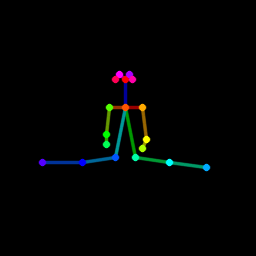

In [53]:
img_from_path = 'photo jul 24 2023, 4 21 37 pm.jpg'
img_from = Image.open(img_from_path).convert("RGB")
img_from.resize((256, 256))

trans = transforms.Compose([
    transforms.Resize([256, 256], interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
img_from_tensor = trans(img_from).unsqueeze(0)
print(img_from_tensor.shape)



pose_img_tensor = build_pose_img().unsqueeze(0)
Image.fromarray((pose_img_tensor[0][:3].permute((1, 2, 0)) * 255.).long().numpy().astype(np.uint8))

In [54]:
with torch.no_grad():
    c_new, down_block_additional_residuals, up_block_additional_residuals = model({
        "img_cond": img_from_tensor.cuda(), "pose_img": pose_img_tensor.cuda()})
    noisy_latents = torch.randn((1, 4, 64, 64)).cuda()
    weight_dtype = torch.float32
    bsz = 1

    c_new = torch.cat([c_new[:bsz], c_new[:bsz], c_new[bsz:]])
    down_block_additional_residuals = [torch.cat([torch.zeros_like(sample), sample, sample]).to(dtype=weight_dtype) \
                                        for sample in down_block_additional_residuals]
    up_block_additional_residuals = {k: torch.cat([torch.zeros_like(v), torch.zeros_like(v), v]).to(dtype=weight_dtype) \
                                        for k, v in up_block_additional_residuals.items()}

    noise_scheduler.set_timesteps(cfg.TEST.NUM_INFERENCE_STEPS)
    for t in noise_scheduler.timesteps:
        inputs = torch.cat([noisy_latents, noisy_latents, noisy_latents], dim=0)
        inputs = noise_scheduler.scale_model_input(inputs, timestep=t)
        noise_pred = unet(sample=inputs, timestep=t, encoder_hidden_states=c_new,
            down_block_additional_residuals=copy.deepcopy(down_block_additional_residuals),
            up_block_additional_residuals=copy.deepcopy(up_block_additional_residuals))

        noise_pred_uc, noise_pred_down, noise_pred_full = noise_pred.chunk(3)
        noise_pred = noise_pred_uc + \
                        cfg.TEST.DOWN_BLOCK_GUIDANCE_SCALE * (noise_pred_down - noise_pred_uc) + \
                        cfg.TEST.FULL_GUIDANCE_SCALE * (noise_pred_full - noise_pred_down)
        noisy_latents = noise_scheduler.step(noise_pred, t, noisy_latents)[0]

    sampling_imgs = vae.decode(noisy_latents) * 0.5 + 0.5 # denormalize
    sampling_imgs = sampling_imgs.clamp(0, 1)

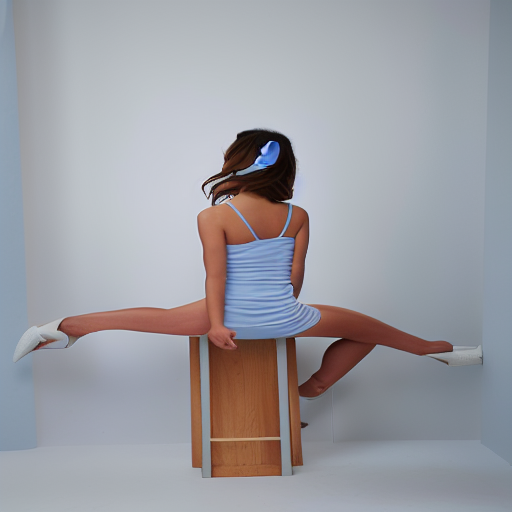

In [55]:
Image.fromarray((sampling_imgs[0] * 255.).permute((1, 2, 0)).long().cpu().numpy().astype(np.uint8)).resize((512, 512))
